# Multi-Prompt HyDE: Data Analysis and Insights
**Philip Offermans**  
*Cognitive Science and Artificial Intelligence | u440541*

## Importing Necessary Modules

In [1]:
import glob
import os
import pandas as pd
import re
import seaborn as sns
import json
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, shapiro, levene, ttest_ind

os.chdir("/Users/philip/Projects/thesis/data_analyse")

## Data Merging & Aggregation

In [2]:
def get_avg_std(file):
    # Reads a CSV file and calculates the mean of the 'std' column
    df = pd.read_csv(file)
    return df['std'].mean()  # Efficiently calculate the mean of the 'std' column

# Get all the CSV file paths
files = glob.glob('./*/*/*output.csv')

directories = []
# Get filepaths
for file in files:
    directory_path = os.path.dirname(file)
    directories.append(directory_path)
directories = set(directories)


# Initialize the final DataFrame with no initial data
results_df = pd.DataFrame()

run = 0
for directory in directories:
    files = glob.glob(f'./{directory}/*output.csv')
    
    for file in files:
        # Extract the filename and directory path of the current file
        filename = os.path.basename(file)
        directory_path = os.path.dirname(file)
        
        # Clean the filename by removing the specific suffix '-top1000-8rep-output.csv'
        cleaned_filename = re.sub(r'-top1000-8rep-output\.csv$', '', filename)
        
        # Read the current file into a DataFrame
        df = pd.read_csv(file)
        df['Run'] = run
        
        # Look for a corresponding 'std' file in the same directory with potential extra characters in the name
        path = os.path.join(directory_path, f'{cleaned_filename}-top1000-8rep-std.csv')
        std_file = glob.glob(path)  # Match any file fitting this pattern
        
        if std_file:  # If a matching std file is found
            # Calculate the average of the 'std' column using the helper function
            std = get_avg_std(std_file[0])
            
            # Create a new DataFrame row with the 'std' metric, value, and associated configuration name
            new_row = pd.DataFrame({
                'Metric': ['std'],  # Label the metric as 'std'
                'Value': [std],     # Add the calculated mean
                'Configuration': cleaned_filename,  # Associate it with the configuration name
                'Run': run,
            })
            
            # Append the new row to `results_df` using pd.concat
            results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Add a unique identifier for the current file to a new column in its DataFrame
        df['Configuration'] = cleaned_filename
        
        # Append the current file's data to `results_df` using pd.concat
        results_df = pd.concat([results_df, df], ignore_index=True)
    run += 1
        
# Sort by "Configuration" and "Metric" to organize by filename and metric
results_df = results_df.sort_values(by=["Configuration", "Metric"])

# Create a mapping of unique configuration names to acronyms
configuration_to_acronym = {
    'dl19-contriever': 'dl19-contriever',
    'single_prompt-hyde-web_search_novice-dl19-contriever-llama3.1-0.7': 'H-0.7-WSN',
    'single_prompt-hyde-web_search_intermediate-dl19-contriever-llama3.1-0.7': 'H-0.7-WSI',
    'single_prompt-hyde-web_search_proficient-dl19-contriever-llama3.1-0.7': 'H-0.7-WSP',
    'single_prompt-hyde-web_search_expert-dl19-contriever-llama3.1-0.7': 'H-0.7-WSE',
    'single_prompt-hyde-web_search-dl19-contriever-llama3.1-0.7': 'H-0.7-WS',
    'single_prompt-hyde-web_search-dl19-contriever-llama3.1-0.35': 'H-0.35-WS',
    'single_prompt-hyde-web_search-dl19-contriever-llama3.1-0.0': 'H-0-WS',
    'multi_prompt-hyde-2web_search-2web_search_novice-2web_search_intermediate-2web_search_expert-dl19-contriever-llama3.1-0.7': 'MPH-0.7-MWS1',
    'multi_prompt-hyde-2web_search-2web_search_novice-2web_search_intermediate-2web_search_expert-dl19-contriever-llama3.1-0.35': 'MPH-0.35-MWS1',
    'multi_prompt-hyde-2web_search-2web_search_novice-2web_search_intermediate-2web_search_expert-dl19-contriever-llama3.1-0.0': 'MPH-0-MWS1',
    'multi_prompt-hyde-2web_search_novice-2web_search_intermediate-2web_search_proficient-2web_search_expert-dl19-contriever-llama3.1-0.7': 'MPH-0.7-MWS2',
    'multi_prompt-hyde-2web_search_novice-2web_search_intermediate-2web_search_proficient-2web_search_expert-dl19-contriever-llama3.1-0.35': 'MPH-0.35-MWS2',
    'multi_prompt-hyde-2web_search_novice-2web_search_intermediate-2web_search_proficient-2web_search_expert-dl19-contriever-llama3.1-0.0': 'MPH-0-MWS2'
}

# Rename configurations in the DataFrame using the mapping
results_df['Configuration'] = results_df['Configuration'].map(configuration_to_acronym)

# Save the final DataFrame to a CSV file named 'results.csv'
results_df.to_csv('results.csv', index=False)

## Number of configurations per Configuration

In [3]:
# Group by 'Configuration' and 'Metric' and count occurrences
configuration_value_counts = results_df.groupby(['Configuration', 'Metric']).size().reset_index(name='Count')

display(configuration_value_counts)

,Configuration,Metric,Count
0,H-0-WS,map,19
1,H-0-WS,ndcg_cut.10,19
2,H-0-WS,recall.1000,19
3,H-0-WS,std,2
4,H-0.35-WS,map,19
5,H-0.35-WS,ndcg_cut.10,19
6,H-0.35-WS,recall.1000,19
7,H-0.35-WS,std,2
8,H-0.7-WS,map,19
9,H-0.7-WS,ndcg_cut.10,19


## Visualizing Average Metric Values per Configuration with Heatmaps

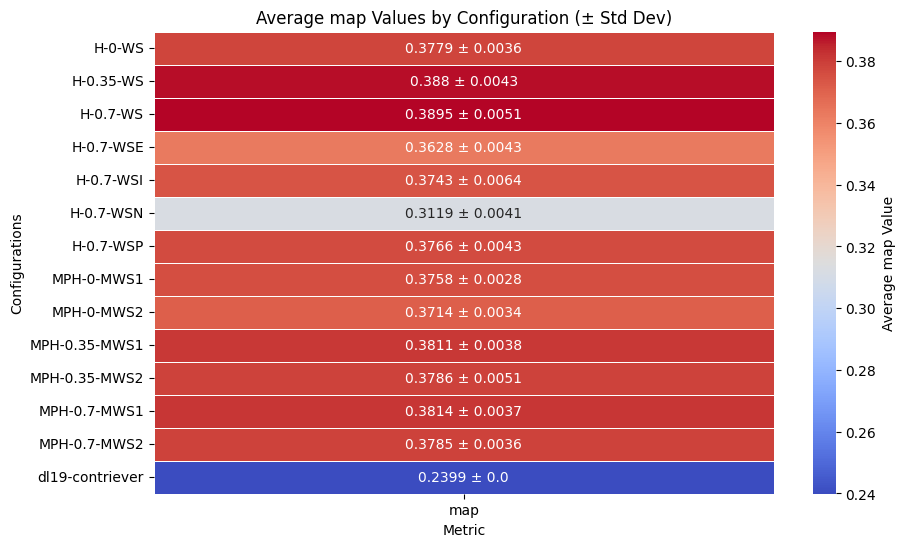

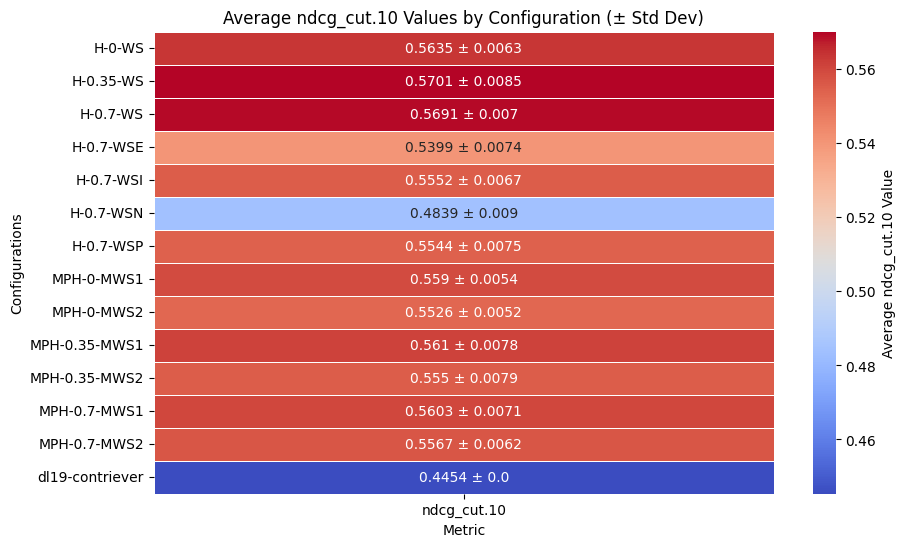

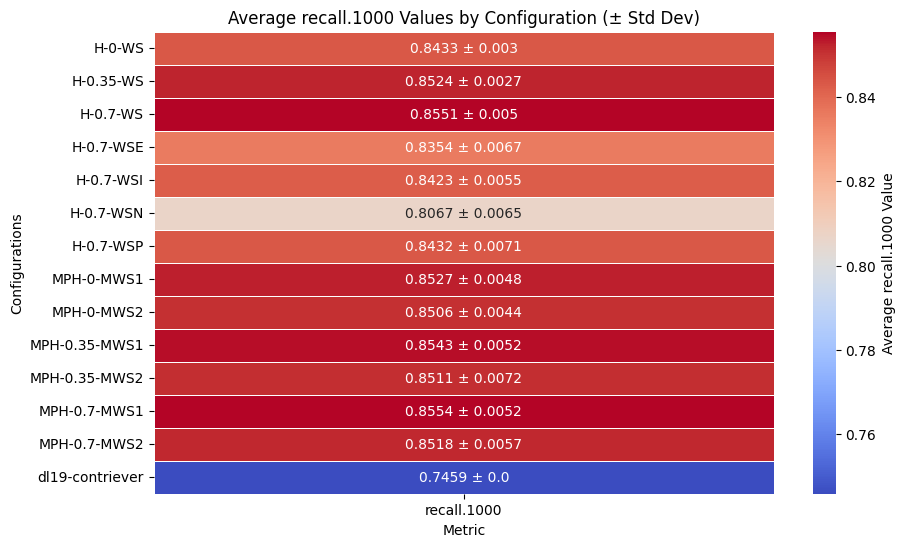

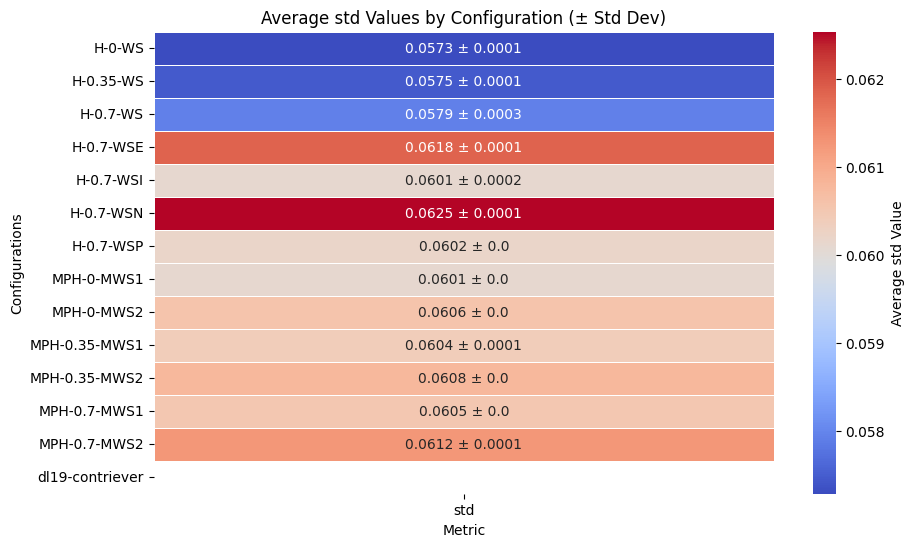

In [4]:
# Calculate the average and standard deviation for each metric for each unique configuration
aggregated_matrix = results_df.groupby(['Configuration', 'Metric'])['Value'].agg(['mean', 'std']).unstack()

# Separate average and standard deviation matrices
average_matrix = aggregated_matrix['mean']
std_matrix = aggregated_matrix['std']

# Plot heatmaps for each metric's average and include std in the annotations
metrics = average_matrix.columns  # Get list of metrics
for metric in metrics:
    plt.figure(figsize=(10, 6))

    # Combine average and std into annotations (std to the right of mean)
    annotations = average_matrix[[metric]].round(4).astype(str) + " ± " + std_matrix[[metric]].round(4).astype(str)

    sns.heatmap(average_matrix[[metric]], annot=annotations.values, fmt="", cmap="coolwarm", linewidths=0.5,
                cbar_kws={"label": f"Average {metric} Value"})

    # Set plot labels and title
    plt.title(f"Average {metric} Values by Configuration (± Std Dev)")
    plt.xlabel("Metric")
    plt.ylabel("Configurations")

    # Save and display each heatmap with full layout
    plt.savefig(f"average_std_{metric}_heatmap.png", dpi=300, bbox_inches='tight')  # Ensure full plot is saved
    plt.show()

## Statistical Testing of Multi-Prompt HyDE (MWS1 & MWS2) vs Single-Prompt HyDE 

In [5]:
# Filter data for the specified configurations
configurations_to_compare = [
    "MPH-0.7-MWS1",  # Multi-Prompt HyDE (MWS1)
    "MPH-0.7-MWS2",  # Multi-Prompt HyDE (MWS2)
    "H-0.7-WS"       # Single-Prompt HyDE
]

# Join configuration names into a single string for the filenames
configurations_str = "_".join(configurations_to_compare)

# Filter data for the relevant configurations
filtered_data = results_df[results_df['Configuration'].isin(configurations_to_compare)]

# Group data by configuration and Metric for t-tests and ANOVA
grouped_data = filtered_data.groupby(['Configuration', 'Metric'])

# Prepare a list to store test results
results = []

# Get the list of unique metrics
metrics = filtered_data['Metric'].unique()

# Perform t-tests and ANOVA for each metric
for metric in metrics:
    try:
        # Extract values for the specific metric and configurations
        multi1 = grouped_data.get_group((configurations_to_compare[0], metric))['Value']
        multi2 = grouped_data.get_group((configurations_to_compare[1], metric))['Value']
        single = grouped_data.get_group((configurations_to_compare[2], metric))['Value']
        
        # Test for normality using Shapiro-Wilk test
        def test_normality(sample):
            stat, p = shapiro(sample)
            return p > 0.03  # Normal if p-value > 0.05

        normal_multi1 = test_normality(multi1)
        normal_multi2 = test_normality(multi2)
        normal_single = test_normality(single)
        
        if not (normal_multi1 and normal_multi2 and normal_single):
            print(f"Warning: Non-normal distribution detected for metric '{metric}'")
            continue  # Skip t-tests if any group is non-normal
        
        # Test for equal variances using Levene's test
        def perform_ttest(sample1, sample2):
            stat, p = levene(sample1, sample2)
            equal_var = p > 0.05  # Use equal variances if Levene's test p-value > 0.05
            return ttest_ind(sample1, sample2, equal_var=equal_var)
        
        # Conduct t-tests dynamically
        multi1_vs_single = perform_ttest(multi1, single)
        multi2_vs_single = perform_ttest(multi2, single)
        multi1_vs_multi2 = perform_ttest(multi1, multi2)
        
        # Perform one-way ANOVA
        anova_stat, anova_p = f_oneway(multi1, multi2, single)
        
        # Append results
        results.append({
            'Metric': metric,
            f'{configurations_to_compare[0]} vs {configurations_to_compare[2]} t': multi1_vs_single.statistic,
            f'{configurations_to_compare[0]} vs {configurations_to_compare[2]} p': multi1_vs_single.pvalue,
            f'{configurations_to_compare[1]} vs {configurations_to_compare[2]} t': multi2_vs_single.statistic,
            f'{configurations_to_compare[1]} vs {configurations_to_compare[2]} p': multi2_vs_single.pvalue,   
            f'{configurations_to_compare[0]} vs {configurations_to_compare[1]} t': multi1_vs_multi2.statistic,
            f'{configurations_to_compare[0]} vs {configurations_to_compare[1]} p': multi1_vs_multi2.pvalue,
            'ANOVA F': anova_stat,
            'ANOVA p': anova_p
        })
    except KeyError:
        # Skip metrics that are not present for all configurations
        continue

# Convert results to a DataFrame
test_results = pd.DataFrame(results)

# Convert underscores to spaces in column names for better readability
test_results.columns = test_results.columns.str.replace('_', ' ')

# Display the results
display(test_results)

# Calculate the average for each metric for each unique configuration
average_matrix = filtered_data.groupby(['Configuration', 'Metric'])['Value'].mean().unstack()

display(average_matrix)

# Calculate the average and standard deviation for each metric for each unique configuration
stats_matrix = filtered_data.groupby(['Configuration', 'Metric'])['Value'].agg(['mean', 'std']).unstack()

# Display the stats matrix with averages and standard deviations
display(stats_matrix)

# Report the results for averages and standard deviations
for metric in stats_matrix['mean'].columns:  # Loop through each metric
    print(f"Metric: {metric}")
    print("Configuration-wise Statistics:")
    for config in stats_matrix['mean'].index:
        avg = stats_matrix['mean'].loc[config, metric]
        std = stats_matrix['std'].loc[config, metric]
        print(f"  {config}: Mean = {avg:.4f}, Std = {std:.4f}")
    print("\n")
    

# # Plot heatmaps for each metric
# for metric in average_matrix.columns:
#     plt.figure(figsize=(10, 6))
#     sns.heatmap(
#         average_matrix[[metric]], annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5,
#         cbar_kws={"label": f"Average {metric} Value"}
#     )

#     # Set plot labels and title
#     plt.title(f"Average {metric} Values by configuration")
#     plt.xlabel("Metric")
#     plt.ylabel("Configurations")

#     # Save and display each heatmap with descriptive filenames
#     filename = f"average_{metric}_heatmap_{configurations_str}.png"
#     plt.savefig(filename, dpi=300, bbox_inches='tight')  # Ensure full plot is saved
#     plt.show()

/var/folders/_2/c8p02kn93cx319kmrhqs71c80000gn/T/ipykernel_8541/3104768821.py:33: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = shapiro(sample)


,Metric,MPH-0.7-MWS1 vs H-0.7-WS t,MPH-0.7-MWS1 vs H-0.7-WS p,MPH-0.7-MWS2 vs H-0.7-WS t,MPH-0.7-MWS2 vs H-0.7-WS p,MPH-0.7-MWS1 vs MPH-0.7-MWS2 t,MPH-0.7-MWS1 vs MPH-0.7-MWS2 p,ANOVA F,ANOVA p
0,map,-5.575978,0.000003,-7.698724,4.067622e-09,2.515568,0.016486,35.334395,1.545868e-10
1,ndcg_cut.10,-3.873065,0.000436,-5.796990,1.298012e-06,1.636925,0.110360,16.866556,2.038056e-06
2,recall.1000,0.209854,0.834964,-1.881142,6.805967e-02,2.040130,0.048726,2.690189,7.696116e-02


Metric,map,ndcg_cut.10,recall.1000,std
Configuration,,,,
H-0.7-WS,0.389526,0.569111,0.855084,0.057936
MPH-0.7-MWS1,0.381432,0.560253,0.855432,0.060515
MPH-0.7-MWS2,0.378458,0.556695,0.851800,0.061249


mean                                         std  \
Metric              map ndcg_cut.10 recall.1000       std       map   
Configuration                                                         
H-0.7-WS       0.389526    0.569111    0.855084  0.057936  0.005136   
MPH-0.7-MWS1   0.381432    0.560253    0.855432  0.060515  0.003696   
MPH-0.7-MWS2   0.378458    0.556695    0.851800  0.061249  0.003590   

                                                 
Metric        ndcg_cut.10 recall.1000       std  
Configuration                                    
H-0.7-WS         0.006956    0.004988  0.000268  
MPH-0.7-MWS1     0.007141    0.005213  0.000017  
MPH-0.7-MWS2     0.006226    0.005747  0.000140

Metric: map
Configuration-wise Statistics:
  H-0.7-WS: Mean = 0.3895, Std = 0.0051
  MPH-0.7-MWS1: Mean = 0.3814, Std = 0.0037
  MPH-0.7-MWS2: Mean = 0.3785, Std = 0.0036


Metric: ndcg_cut.10
Configuration-wise Statistics:
  H-0.7-WS: Mean = 0.5691, Std = 0.0070
  MPH-0.7-MWS1: Mean = 0.5603, Std = 0.0071
  MPH-0.7-MWS2: Mean = 0.5567, Std = 0.0062


Metric: recall.1000
Configuration-wise Statistics:
  H-0.7-WS: Mean = 0.8551, Std = 0.0050
  MPH-0.7-MWS1: Mean = 0.8554, Std = 0.0052
  MPH-0.7-MWS2: Mean = 0.8518, Std = 0.0057


Metric: std
Configuration-wise Statistics:
  H-0.7-WS: Mean = 0.0579, Std = 0.0003
  MPH-0.7-MWS1: Mean = 0.0605, Std = 0.0000
  MPH-0.7-MWS2: Mean = 0.0612, Std = 0.0001




## Statistical Testing of Multi-Prompt HyDE (MWS2) vs Average of Single-Prompt HyDEs (WSN, WSI, WSP, WSE)



In [6]:
# List of configurations to analyze separately
separate_configuration_names = [
    "H-0.7-WSN",
    "H-0.7-WSI",
    "H-0.7-WSP",
    "H-0.7-WSE",
]

# Combined identifier for separate configurations
separate_configuration_combined_name = "+".join(separate_configuration_names)

# Combined configuration to compare against
combined_configuration_name = "MPH-0.7-MWS2"

# Filter the dataset for separate configurations
filtered_separate_configurations = results_df[results_df['Configuration'].isin(separate_configuration_names)]

# Find the maximum value in the 'Run' column
max_run_value = filtered_separate_configurations["Run"].max()

# Initialize a DataFrame to store aggregated results
aggregated_results_df = pd.DataFrame()

# Iterate through each run to process data
for run_number in range(max_run_value + 1):  # Include the maximum run
    # Filter data for the current run
    current_run_data = filtered_separate_configurations[filtered_separate_configurations['Run'] == run_number]
    
    # Extract unique metrics for the current run
    unique_metrics_in_run = current_run_data['Metric'].unique()
    
    # Process each metric within the current run
    for metric_name in unique_metrics_in_run:
        # Filter data for the current metric
        metric_data = current_run_data[current_run_data['Metric'] == metric_name]

        # Calculate the mean value for the current metric and run
        mean_metric_value = metric_data['Value'].mean()
        
        # Create a new row to store the results
        new_row = pd.DataFrame({
            'Metric': [metric_name],  # Name of the metric
            'Value': [mean_metric_value],  # Mean value
            'Configuration': [separate_configuration_combined_name],  # Combined configuration name
            'Run': [run_number],  # Current run number
        })
        
        # Append the new row to the aggregated results
        aggregated_results_df = pd.concat([aggregated_results_df, new_row], ignore_index=True)

# Filter the dataset for the combined configuration
filtered_combined_configuration_data = results_df[results_df['Configuration'] == combined_configuration_name]

# Combine aggregated results and filtered combined configuration data
final_results_df = pd.concat([aggregated_results_df, filtered_combined_configuration_data], ignore_index=True)

final_results_df.to_csv("inspect.csv", index=False)
# Perform t-tests for each metric

# Group the final results by configuration and metric
grouped_results = final_results_df.groupby(['Configuration', 'Metric'])

# Prepare a list to store t-test results
t_test_results = []

# Get the list of unique metrics
unique_metrics = final_results_df['Metric'].unique()

# Perform t-tests for each metric
for metric_name in unique_metrics:
    try:
        # Extract values for the separate configurations and combined configuration
        separate_combined_values = grouped_results.get_group((separate_configuration_combined_name, metric_name))['Value']
        combined_configuration_values = grouped_results.get_group((combined_configuration_name, metric_name))['Value']
        
        # Test for normality using Shapiro-Wilk test
        def is_normal_distribution(values):
            _, p_value = shapiro(values)
            return p_value > 0.05  # Normal if p-value > 0.05

        separate_is_normal = is_normal_distribution(separate_combined_values)
        combined_is_normal = is_normal_distribution(combined_configuration_values)
        
        if not (separate_is_normal and combined_is_normal):
            print(f"Warning: Non-normal distribution detected for metric '{metric_name}'")
            continue  # Skip metrics with non-normal distributions
        
        # Test for equal variances using Levene's test
        def perform_t_test(group1, group2):
            _, p_value = levene(group1, group2)
            equal_variance = p_value > 0.05  # True if variances are equal
            return ttest_ind(group1, group2, equal_var=equal_variance)

        # Perform the t-test
        t_statistic, p_value = perform_t_test(separate_combined_values, combined_configuration_values)
        
        # Append the t-test results to the list
        t_test_results.append({
            'Metric': metric_name,
            't-statistic': t_statistic,
            'p-value': p_value,
        })
    except KeyError:
        # Skip metrics that are not present in all configurations
        continue

# Convert t-test results into a DataFrame
t_test_results_df = pd.DataFrame(t_test_results)

# Display the t-test results
display(t_test_results_df)

# Calculate average values for each metric and configuration
# average_metric_matrix = final_results_df.groupby(['Configuration', 'Metric'])['Value'].mean().unstack()
stats_matrix = final_results_df.groupby(['Configuration', 'Metric'])['Value'].agg(['mean', 'std']).unstack()

# Display the average metric matrix
display(stats_matrix)

/var/folders/_2/c8p02kn93cx319kmrhqs71c80000gn/T/ipykernel_8541/633208430.py:78: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_value = shapiro(values)


,Metric,t-statistic,p-value
0,map,-21.855928,2.273248e-22
1,ndcg_cut.10,-13.811870,1.212437e-14
2,recall.1000,-12.724754,6.894720e-15


mean                          \
Metric                                        map ndcg_cut.10 recall.1000   
Configuration                                                               
H-0.7-WSN+H-0.7-WSI+H-0.7-WSP+H-0.7-WSE  0.356409    0.533351    0.831884   
MPH-0.7-MWS2                             0.378458    0.556695    0.851800   

                                                        std              \
Metric                                        std       map ndcg_cut.10   
Configuration                                                             
H-0.7-WSN+H-0.7-WSI+H-0.7-WSP+H-0.7-WSE  0.061175  0.002539    0.003938   
MPH-0.7-MWS2                             0.061249  0.003590    0.006226   

                                                               
Metric                                  recall.1000       std  
Configuration                                                  
H-0.7-WSN+H-0.7-WSI+H-0.7-WSP+H-0.7-WSE    0.003676  0.000102  
MPH-0.7-MWS2                               0.005747  0.000140

## Checking the STD

In [24]:
# List of configurations to analyze separately
separate_configuration_names = [
    "H-0.7-WSN",
    "H-0.7-WSI",
    "H-0.7-WSP",
    "H-0.7-WSE",
]

# Combined identifier for separate configurations
separate_configuration_combined_name = "+".join(separate_configuration_names)

# Initialize an empty list to collect results
results = []

# Analyze separate configurations
filtered_separate_configurations = results_df[results_df['Configuration'].isin(separate_configuration_names)]
unique_configurations = filtered_separate_configurations['Configuration'].unique()

for configuration in unique_configurations:
    metrics = filtered_separate_configurations[
        filtered_separate_configurations['Configuration'] == configuration
    ]['Metric'].unique()
    
    for metric in metrics:
        filtered_data = filtered_separate_configurations[
            (filtered_separate_configurations['Configuration'] == configuration) &
            (filtered_separate_configurations['Metric'] == metric)
        ]
        average = filtered_data['Value'].mean()
        standard_deviation = filtered_data['Value'].std()
        
        # Append results to the list
        results.append({
            'Configuration': configuration,
            'Metric': metric,
            'Average': average,
            'Standard Deviation': standard_deviation
        })

# Analyze combined configuration
filtered_data = final_results_df[
    final_results_df['Configuration'] == separate_configuration_combined_name
]
metrics = filtered_data['Metric'].unique()

for metric in metrics:
    metric_data = filtered_data[filtered_data['Metric'] == metric]
    average = metric_data['Value'].mean()
    standard_deviation = metric_data['Value'].std()
    
    # Append results to the list
    results.append({
        'Configuration': separate_configuration_combined_name,
        'Metric': metric,
        'Average': average,
        'Standard Deviation': standard_deviation
    })

# Create a DataFrame from the results list
results_table = pd.DataFrame(results)

# Display the table
print(results_table)
results_table.to_csv("results_analysis.csv", index=False)

                              Configuration       Metric   Average  \
0                                 H-0.7-WSE          map  0.362837   
1                                 H-0.7-WSE  ndcg_cut.10  0.539905   
2                                 H-0.7-WSE  recall.1000  0.835421   
3                                 H-0.7-WSE          std  0.061847   
4                                 H-0.7-WSI          map  0.374311   
5                                 H-0.7-WSI  ndcg_cut.10  0.555200   
6                                 H-0.7-WSI  recall.1000  0.842284   
7                                 H-0.7-WSI          std  0.060111   
8                                 H-0.7-WSN          map  0.311911   
9                                 H-0.7-WSN  ndcg_cut.10  0.483884   
10                                H-0.7-WSN  recall.1000  0.806679   
11                                H-0.7-WSN          std  0.062539   
12                                H-0.7-WSP          map  0.376579   
13                  

## Difference in Metrics between temperatures

In [8]:
# Create an empty DataFrame to store results
comparisons = pd.DataFrame()

# Define the temperatures
temperatures = ["0", "0.35", "0.7"]

# Loop through the temperatures and calculate differences
for temperature in temperatures:
    hyde = f"H-{temperature}-WS"
    multi_prompt_hyde = f"MPH-{temperature}-MWS2"
    
    # Filter the data for the two configurations
    config_h = results_df[results_df['Configuration'] == hyde]
    config_mph2 = results_df[results_df['Configuration'] == multi_prompt_hyde]
    
    # Merge the two datasets on Metric and Run to align rows
    merged = config_h.merge(config_mph2, on=['Metric', 'Run'], suffixes=('_h', '_mph2'))
    
    # Subtract the 'Value' columns
    merged['Value_diff'] = merged['Value_h'] - merged['Value_mph2']
    
    # Add a column for the comparison being made
    merged['Comparison'] = temperature
    
    # Keep only the relevant columns
    result_matrix = merged[['Comparison', 'Metric', 'Run', 'Value_diff']]
    
    # Append to the combined DataFrame
    comparisons = pd.concat([comparisons, result_matrix], ignore_index=True)

# Group data by configuration and Metric for t-tests and ANOVA
grouped_data = comparisons.groupby(['Comparison', 'Metric'])

# Prepare a list to store test results
results = []

# Get the list of unique metrics
metrics = comparisons['Metric'].unique()

# Perform t-tests and ANOVA for each metric
for metric in metrics:
    try:
        # Extract values for the specific metric and configurations
        zero = grouped_data.get_group(('0', metric))['Value_diff']
        zeropointthreefive = grouped_data.get_group(('0.35', metric))['Value_diff']
        zeropointseven = grouped_data.get_group(('0.7', metric))['Value_diff']
        
        # Test for normality using Shapiro-Wilk test
        def test_normality(sample):
            stat, p = shapiro(sample)
            return p > 0.05  # Normal if p-value > 0.05

        normal_zero = test_normality(zero)
        normal_zeropointthreefive = test_normality(zeropointthreefive)
        normal_zeropointseven = test_normality(zeropointseven)
        
        if not (normal_zero and normal_zeropointthreefive and normal_zeropointseven):
            print(f"Warning: Non-normal distribution detected for metric '{metric}'")
            continue  # Skip t-tests if any group is non-normal
        
        # Test for equal variances using Levene's test
        def perform_ttest(sample1, sample2):
            stat, p = levene(sample1, sample2)
            equal_var = p > 0.05  # Use equal variances if Levene's test p-value > 0.05
            return ttest_ind(sample1, sample2, equal_var=equal_var)
        
        # Conduct t-tests dynamically
        zero_vs_zeropointseven = perform_ttest(zero, zeropointseven)
        zeropointthreefive_vs_zeropointseven = perform_ttest(zeropointthreefive, zeropointseven)
        zero_vs_zeropointthreefive = perform_ttest(zero, zeropointthreefive)
        
        # Perform one-way ANOVA
        anova_stat, anova_p = f_oneway(zero, zeropointthreefive, zeropointseven)
        
        # Append results
        results.append({
            'Metric': metric,
            '0 vs 0.7 t': zero_vs_zeropointseven.statistic,
            '0 vs 0.7 p': zero_vs_zeropointseven.pvalue,
            '0.35 vs 0.7 t': zeropointthreefive_vs_zeropointseven.statistic,
            '0.35 vs 0.7 p': zeropointthreefive_vs_zeropointseven.pvalue,   
            '0 vs 0.35 t': zero_vs_zeropointthreefive.statistic,
            '0 vs 0.35 p': zero_vs_zeropointthreefive.pvalue,
            'ANOVA_F': anova_stat,
            'ANOVA_p': anova_p
        })
    except KeyError:
        # Skip metrics that are not present for all configurations
        continue

# Convert results to a DataFrame
test_results = pd.DataFrame(results)

# Convert underscores to spaces in column names for better readability
test_results.columns = test_results.columns.str.replace('_', ' ')

# Display the results
display(test_results)

# # Calculate the average for each metric for each unique configuration
# average_matrix = comparisons.groupby(['Comparison', 'Metric'])['Value_diff'].mean().unstack()
# display(average_matrix)

# Calculate average values for each metric and configuration
# average_metric_matrix = final_results_df.groupby(['Comparison', 'Metric'])['Value_diff'].mean().unstack()
stats_matrix = comparisons.groupby(['Comparison', 'Metric'])['Value_diff'].agg(['mean', 'std']).unstack()

# Display the average metric matrix
display(stats_matrix)
# # Plot heatmaps for each metric
# for metric in average_matrix.columns:
#     for comparison in temperatures:
#         plt.figure(figsize=(10, 6))
#         sns.heatmap(
#             average_matrix[[metric]], annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5,
#             cbar_kws={"label": f"Average {metric} Value"}
#         )

#         # Set plot labels and title
#         plt.title(f"Average {metric} Values for Comparison: H-{comparison}-WS vs MPH-{comparison}-MWS2")
#         plt.xlabel("Metric")
#         plt.ylabel("Configurations")

#         # Save each heatmap with a descriptive filename
#         filename = f"average_{metric}_heatmap_H-{comparison}-WS_vs_MPH-{comparison}-MWS2.png"
#         plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with descriptive name
#         print(f"Saved heatmap as {filename}")  # Log the saved filename
#         plt.show()



/var/folders/_2/c8p02kn93cx319kmrhqs71c80000gn/T/ipykernel_8541/911700922.py:50: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = shapiro(sample)


,Metric,0 vs 0.7 t,0 vs 0.7 p,0.35 vs 0.7 t,0.35 vs 0.7 p,0 vs 0.35 t,0 vs 0.35 p,ANOVA F,ANOVA p
0,map,-2.412987,0.021040,-0.750292,0.457955,-1.384170,0.174828,2.486976,0.092641
1,ndcg_cut.10,-0.489052,0.627771,0.684293,0.498172,-1.177445,0.246744,0.719358,0.491673
2,recall.1000,-4.808005,0.000027,-0.814997,0.420433,-4.094184,0.000229,12.304166,0.000040


mean                                         std              \
Metric           map ndcg_cut.10 recall.1000       std       map ndcg_cut.10   
Comparison                                                                     
0           0.006511    0.010916   -0.007305 -0.003298  0.005405    0.008065   
0.35        0.009411    0.015063    0.001258 -0.003313  0.007361    0.013065   
0.7         0.011068    0.012416    0.003284 -0.003313  0.006211    0.010663   

                                  
Metric     recall.1000       std  
Comparison                        
0             0.005377  0.000029  
0.35          0.007362  0.000158  
0.7           0.007953  0.000407

## Generating a Cosine Similarity Heatmap for Prompt Style Comparisons

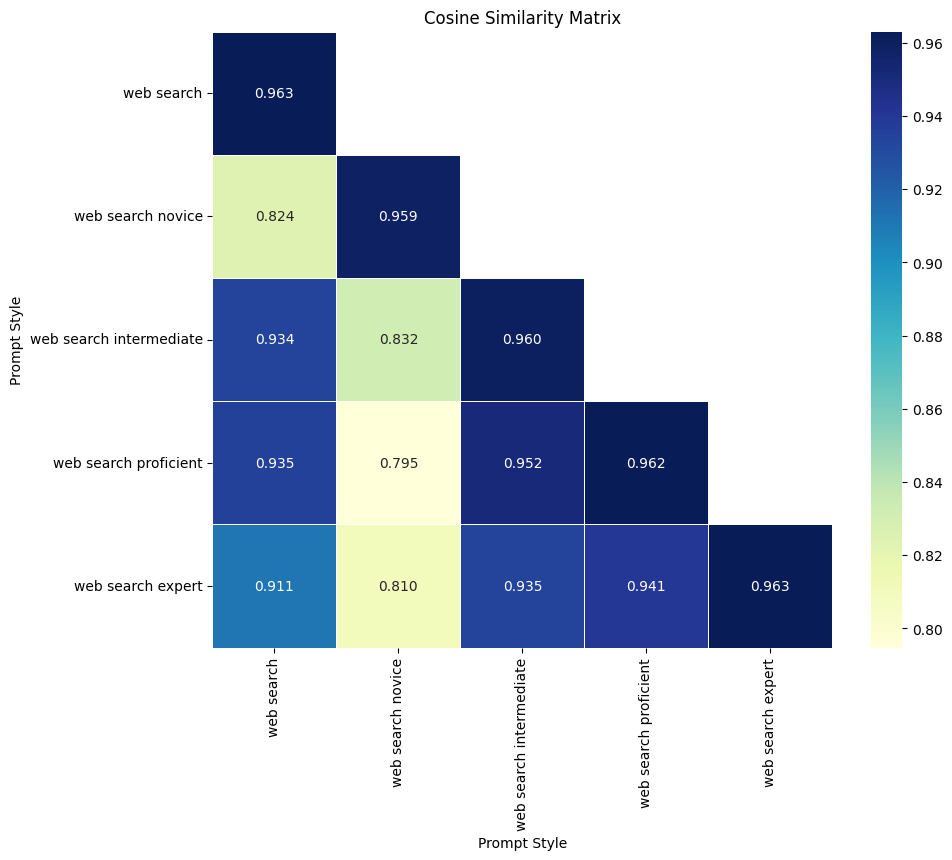

In [16]:
# Load the JSON file
file_path = './runs_cos/run_2/cosine_similarity_results.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize an empty dictionary to store matrix data
matrix_data = {}

# Extract data and calculate averages for each pair
for style1 in data:
    for style2 in data[style1]:
        total = 0
        count = 0
        for question in data[style1][style2]:
            total += data[style1][style2][question][0]
            count += 1
        avg_cossim = total / count
        # Store results in a dictionary format suitable for DataFrame conversion
        if style1 not in matrix_data:
            matrix_data[style1] = {}
        matrix_data[style1][style2] = avg_cossim

# Convert dictionary to a DataFrame to create the matrix table
matrix_df = pd.DataFrame(matrix_data).fillna(0)

# Mask zero values to hide them in the heatmap
mask = matrix_df == 0

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(matrix_df, mask=mask, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
# plt.title('Cosine Similarity Matrix')
# plt.xlabel('Prompt Style')
# plt.ylabel('Prompt Style')
# # Save the plot as an image
# plt.savefig('cosine_similarity_matrix.png', dpi=300, bbox_inches='tight')
# plt.savefig('cosine_similarity_matrix.pgf', format='pgf')  # Save as PGF
# plt.show()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Create a figure and axis explicitly
sns.heatmap(matrix_df, mask=mask, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5, ax=ax)
ax.set_title('Cosine Similarity Matrix')
ax.set_xlabel('Prompt Style')
ax.set_ylabel('Prompt Style')

# Save the plot as an image
plt.savefig('cosine_similarity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()